In [ ]:
!pip install tika

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

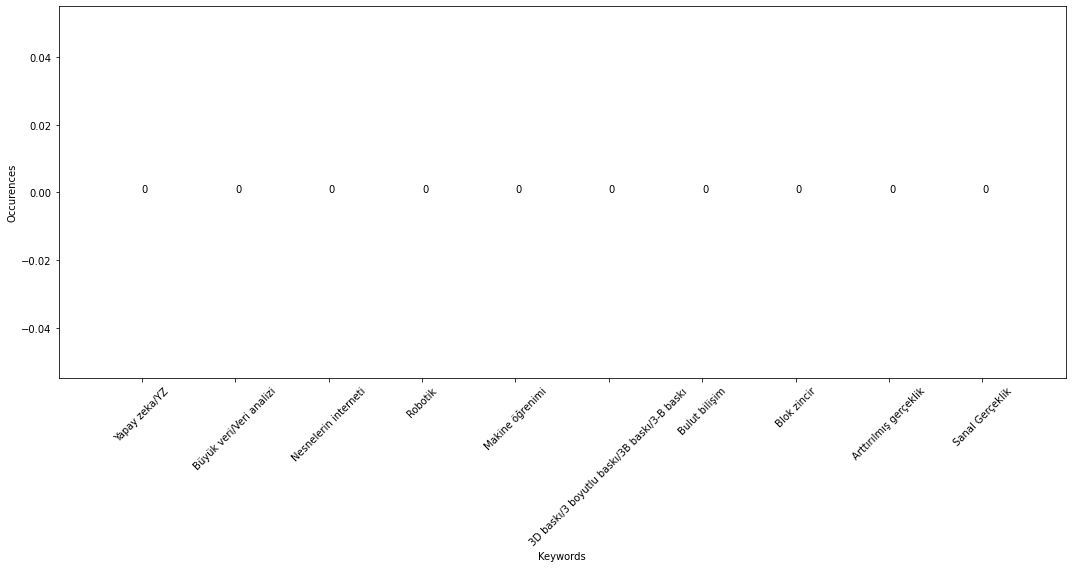

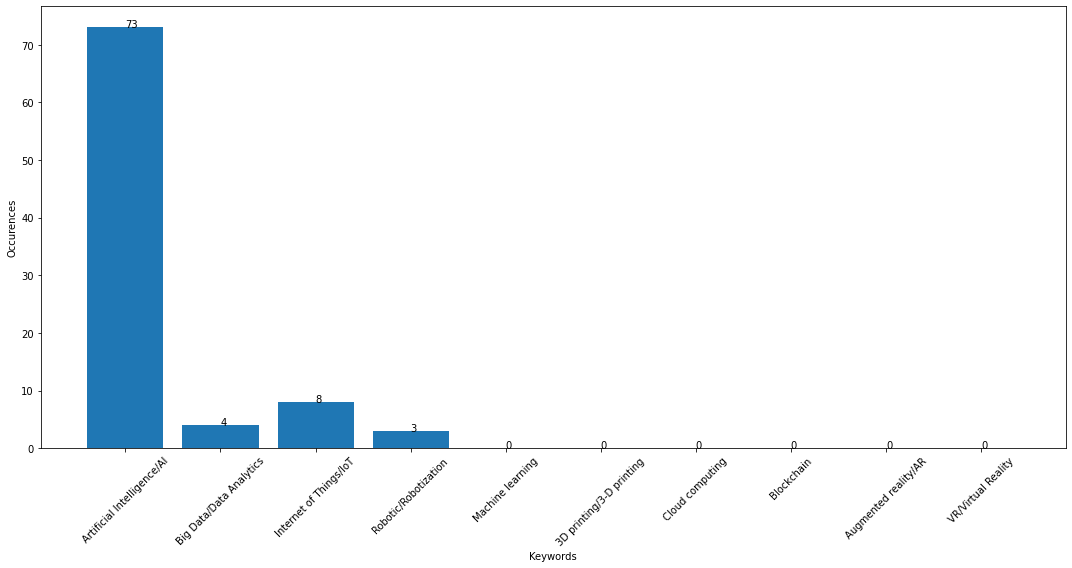

In [42]:
import json
import os
import re
import sys
from tika import parser
import matplotlib.pyplot as plt
from google.colab import files
from typing import Dict, List


class PDFAnalyzer(object):
    def __init__(self, keyword_list: List, directory: str, as_words: bool, use_regex: bool, download_name: str):
        """
        Initialize PDFAnalyzer
            Parameters:
                keyword_list (list): A list that contains keywords.
                 Similar keywords can be grouped, for example:
                    [["Artificial Intelligence", "AI"], ["Big Data"]]
                    "Artificial Intelligence" and "AI" will be searched separately and counted as the same

                directory (str): Directory to search PDFs.
                as_words (bool): If set to true, searches for keywords as words
        """

        # Dict[FileName, Dict[Keyword, Count]]
        self.__histogram: Dict[str, Dict[str, int]] = {}
        self.__download_name: str = download_name
        self.__as_words: bool = as_words
        self.__directory: str = directory
        self.__found_pdfs: List = []
        # Total count of each keyword
        self.__total_count: Dict[str, int] = {}
        self.__use_regex: bool = use_regex

        # If keyword is a word there will be spaces around it.
        if self.__as_words:
            self.__keyword_list: List[List[str]] = [[' ' + keyword + ' ' for keyword in sublist] for sublist in
                                                    keyword_list]
        else:
            self.__keyword_list: List[str] = keyword_list
        self.__find_pdfs()
        self.__analyze_pdfs()
        self.__calculate_total()

    def __find_pdfs(self):
        for root, _, files in os.walk(self.__directory):
            for file in files:
                if file.upper().endswith(".PDF"):
                    self.__found_pdfs.append(root + "/" + file)

    def __analyze_pdfs(self):
        if len(self.__found_pdfs) == 0:
            sys.exit("No PDF files found!")

        for pdf_file in self.__found_pdfs:
            read_pdf = parser.from_file(pdf_file)
            content = read_pdf["content"]
            self.__find_keywords_in_pdf(pdf_file, content)

    def __find_keywords_in_pdf(self, file_name: str, content: str):
        if len(self.__keyword_list) == 0:
            sys.exit("Empty keyword list!")

        for keyword in self.__keyword_list:
            multi_key = '/'.join(keyword).strip()
            for singleKey in keyword:
                if self.__use_regex:
                    matcher = re.findall(r'\b(' + re.escape(singleKey) + r')(?!\w)(?:([-|\'])+(\w+))*', content,
                                         re.IGNORECASE | re.MULTILINE)
                    if matcher is not None:
                        self.__add_to_histogram(file_name, multi_key, len(matcher))
                else:
                    count_in_doc = content.count(singleKey)
                    self.__add_to_histogram(file_name, multi_key, count_in_doc)

    def __add_to_histogram(self, file_name: str, keyword: str, count: int):
        if file_name in self.__histogram:
            if keyword in self.__histogram[file_name]:
                self.__histogram[file_name][keyword] += count
            else:
                self.__histogram[file_name][keyword] = count
        else:
            self.__histogram[file_name] = {keyword: count}
        pass

    def __calculate_total(self):
        for keyList in self.__histogram.values():
            for key in keyList.keys():
                if key in self.__total_count:
                    self.__total_count[key] += keyList[key]
                else:
                    self.__total_count[key] = keyList[key]

    def __add_labels(self, x, y):
        plt.clf()
        for i in range(len(x)):
            plt.text(i, y[i], y[i])

    def get_histogram(self):
        """
        Returns raw histogram data.
        """
        return self.__histogram

    def get_histogram_json(self, minify: bool, j_indent: int = 4):
        """
        Returns histogram data in JSON format.
            Parameters:
                minify (bool): Minify switch for JSON dump.
                j_indent (int): Identation size.
        """
        if minify:
            return json.dumps(self.__histogram, separators=(',', ':'))
        return json.dumps(self.__histogram, indent=j_indent)

    def plot_histogram(self, xlabel: str, ylabel: str, rotation: int = 90):
        """
        Plots histogram data
            Parameters:
                xlabel (str): Label for x-axis
                ylabel (str): Label for y-axis
                rotation (int): Rotation for labels
        """
        x_data = self.__total_count.keys()
        y_data = list(self.__total_count.values())
        plt.figure(figsize=(15,8))
        self.__add_labels(x_data, y_data)
        
        plt.xticks(rotation=rotation)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.bar(*zip(*self.__total_count.items()))
        plt.tight_layout()
        plt.savefig(self.__download_name, dpi=200)
        files.download(self.__download_name+".png")
        



if __name__ == "__main__":

    englishList = [
        ["Artificial Intelligence", "AI"],
        ["Big Data", "Data Analytics"],
        ["Internet of Things", "IoT"],
        ["Robotic", "Robotization"],
        ["Machine learning"],
        ["3D printing", "3-D printing"],
        ["Cloud computing"],
        ["Blockchain"],
        ["Augmented reality", "AR"],
        ["VR", "Virtual Reality"]
    ]

    turkishList = [
        ["Yapay zeka", "YZ"],
        ["Büyük veri", "Veri analizi"],
        ["Nesnelerin interneti"],
        ["Robotik"],
        ["Makine öğrenimi"],
        ["3D baskı", "3 boyutlu baskı", "3B baskı", "3-B baskı"],
        ["Bulut bilişim"],
        ["Blok zincir"],
        ["Arttırılmış gerçeklik"],
        ["Sanal Gerçeklik"]
    ]

    """
    Baştan sona doğru parametreler ve anlamları:
        turkishList: aranacak listenin adı.
        "./PDFs": PDF dosyalarının bulunduğu klasör.
        as_words: Kelimeler aranırken başlarına ve sonlarına boşluk eklenmeli mi evet ise as_words=True hayır ise as_words=False
                  Bu özellik use_regex kullanırken False olmalıdır.
        use_regex: True ise kelimeler regex kurallarına göre aranır.
    """
    PDFAnalyzerEng = PDFAnalyzer(turkishList, "/content/drive/MyDrive/PDFs", as_words=False, use_regex=True, download_name="turkish")
    PDFAnalyzerEng.plot_histogram(xlabel="Keywords", ylabel="Occurences", rotation=45)

    PDFAnalyzerEng = PDFAnalyzer(englishList, "/content/drive/MyDrive/PDFs", as_words=False, use_regex=True, download_name="english")
    PDFAnalyzerEng.plot_histogram(xlabel="Keywords", ylabel="Occurences", rotation=45)